<h1> Assignment 1 </h1>


Checkpoint - 1

In [22]:
from matplotlib.text import Annotation
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import seaborn as sns
from google.colab import widgets
from gym import spaces
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/RL/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL
destination.png  empty.png  gold.png  pit.png  wumpus.png


#Deterministic Environment

In [23]:
class LawnMowerDeterministicEnvironment(gym.Env):
  metadata = {'render.modes' : []} 
  def __init__(self, n_rows = 4, n_columns = 4, A_pos = [0, 0], G_pos = [3, 3], max_steps = 15):
    self.observation_space = spaces.Discrete(n_rows * n_columns)
    self.n_states = n_rows * n_columns
    self.n_rows = n_rows
    self.n_columns = n_columns
    
    # Possible actions [Up, Right, Down, Left]
    self.action_space = spaces.Discrete(4)
    self.n_actions = 4

    # Initialization of the State
    self.state = np.zeros((n_rows, n_columns))

    # Initial position of the Agent
    self.agent_pos = [element for element in A_pos]
    self.start_pos = [element for element in A_pos]

    # Goal position of the Agent
    self.goal_pos = [element for element in G_pos]

    # Positive Rewards Placement
    self.positive_Reward_Pos = [[3, 2], [2, 1], [3, 3]]
    self.state[tuple(self.positive_Reward_Pos[0])] = 10
    self.state[tuple(self.positive_Reward_Pos[1])] = 14
    self.state[tuple(self.goal_pos)] = 20

    # Negative Rewards Placement
    self.negative_Reward_Pos = [[0, 2], [2, 3]]
    self.state[tuple(self.negative_Reward_Pos[0])] = -15
    self.state[tuple(self.negative_Reward_Pos[1])] = -13
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    self.max_Timestep = max_steps
    
    
    
  def reset(self):
    # Initialization of the state
    self.state = np.zeros((self.n_rows, self.n_columns))

    # Initial position of agent
    self.agent_pos = [element for element in self.start_pos]

    # Positive Rewards Placement
    self.state[tuple(self.positive_Reward_Pos[0])] = 5
    self.state[tuple(self.positive_Reward_Pos[1])] = 6
    self.state[tuple(self.goal_pos)] = 10

    # Negative Rewards Placement
    self.state[tuple(self.negative_Reward_Pos[0])] = -5
    self.state[tuple(self.negative_Reward_Pos[1])] = -6
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    
  def clip(self):
    '''clips the position if it goes out of bounds'''
    if self.agent_pos[0] < 0:
      self.agent_pos[0] = 0
    elif self.agent_pos[0] >= self.n_rows:
      self.agent_pos[0] = self.n_rows - 1
    if self.agent_pos[1] < 0:
      self.agent_pos[1] = 0
    elif self.agent_pos[1] >= self.n_columns:
      self.agent_pos[1] = self.n_columns - 1
    pass

  def step(self, action):
    '''
      Input - Action: 0[Up], 1[Right], 2[Down], 3[Left]
      Returns -
        agent_pos - Agent current position after applying the move
        reward - Reward gained by current action
        done - Goal reached status (True/False)
        info - Additional info if any
    '''
    self.state[tuple(self.agent_pos)] = 0

    if action == 0: #Up
      self.agent_pos[0] -= 1
    elif action == 1: #Right
      self.agent_pos[1] += 1
    elif action == 2: #Down
      self.agent_pos[0] += 1
    elif action == 3: #Left
      self.agent_pos[1] -= 1
    
    self.clip()

    cur_reward = self.state[tuple(self.agent_pos)]
    
    self.total_reward += cur_reward
    self.state[tuple(self.agent_pos)] = 1
    self.timestep += 1

    self.done = True if (self.agent_pos == self.goal_pos or self.timestep >= self.max_Timestep) else False
    info = {}
    observation = self.state.flatten()
    return observation, cur_reward, self.done, info
    


  def render(self):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    def plot_image(plot_pos):
      #print(plot_pos)
      plot_agent, plot_gold, plot_pit, plot_dest = False, False, False, False
      if np.array_equal(self.agent_pos, plot_pos):
        plot_agent = True
      elif np.array_equal(plot_pos, self.goal_pos):
        plot_dest = True
      elif self.state[tuple(plot_pos)] > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
        plot_gold = True
      elif self.state[tuple(plot_pos)] < 0:
        plot_pit = True
      #if any(np.array_equal(self.negative_Reward_Pos[i], plot_pos) for i in range(len(self.negative_Reward_Pos))):
       # plot_pit = True
      #if any(np.array_equal(self.postive_Reward_Pos[i], plot_pos) for i in range(len(self.postive_Reward_Pos))):
       # plot_gold = True
      if plot_agent and all(not item for item in
                        [plot_gold, plot_pit, plot_dest]):
        agent = AnnotationBbox(OffsetImage(plt.imread('wumpus.png'), zoom=0.15),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(agent)
      elif plot_gold and \
                    all(not item for item in
                        [plot_agent, plot_pit, plot_dest]):
                gold = AnnotationBbox(OffsetImage(plt.imread('gold.png'), zoom=0.15),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(gold)
      elif plot_pit and \
                    all(not item for item in
                        [plot_gold, plot_agent, plot_dest]):
                pit = AnnotationBbox(OffsetImage(plt.imread('pit.png'), zoom=0.15),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      elif plot_dest and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_agent]):
                pit = AnnotationBbox(OffsetImage(plt.imread('destination.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      else:
        pit = AnnotationBbox(OffsetImage(plt.imread('empty.png'), zoom=0.25),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(pit)
    coordinates_state_mapping_2 = {}
    for j in range(4 * 4):
        coordinates_state_mapping_2[j] = np.asarray(
            [(j % 4), (int(np.floor(j / 4)))])

    # Rendering the images for all states.
    for position in coordinates_state_mapping_2:
      plot_image(coordinates_state_mapping_2[position])

    plt.xticks([0, 1, 2, 3, 4])
    plt.yticks([0, 1, 2, 3, 4])
    plt.grid()
    plt.show()


In [24]:
def RandomAgent(env):
  map_action = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}
  for i in range(2):
    print(f"************* Episode {i+1} *************")
    env.reset()
    print("--------------- initial state ---------------")
    print("current state:", env.agent_pos)
    env.render()

    for step in range(0,env.max_Timestep):
      action = env.action_space.sample()
      observation, reward, done, _ = env.step(action)
      print(f"\n--------------- After Timestep {step+1} ---------------")
      print("current state:", env.agent_pos)
      print("chosen action:",  map_action[action])
      print("reward after current step:",  reward)
      print("Total reward:", env.total_reward)
      env.render()
      if done:
        #env.render()
        print(f"\n ************* Episode {i+1} ends, Cumulative Rewards = {env.total_reward} ************* \n")
        print("\n ************* Resetting the environment ************* \n")
        break



************* Episode 1 *************
--------------- initial state ---------------
current state: [0, 0]


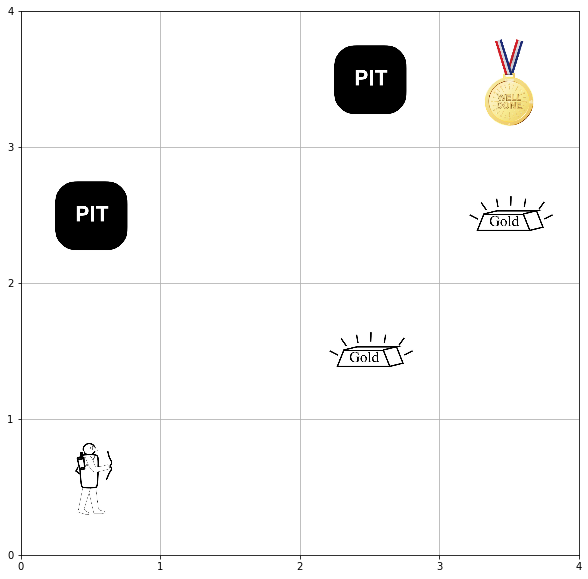


--------------- After Timestep 1 ---------------
current state: [1, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


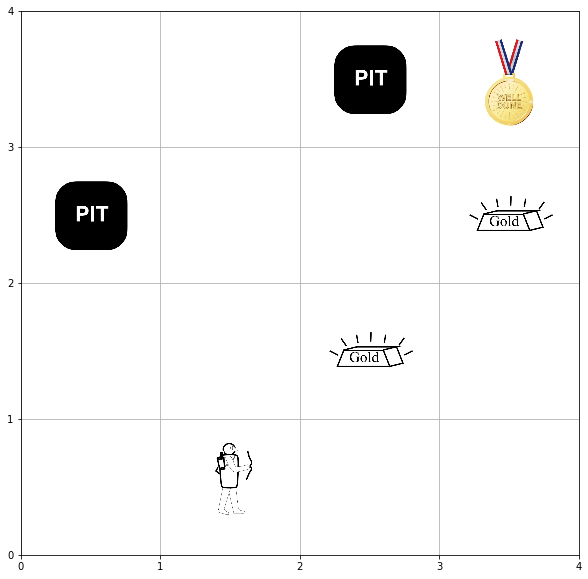


--------------- After Timestep 2 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


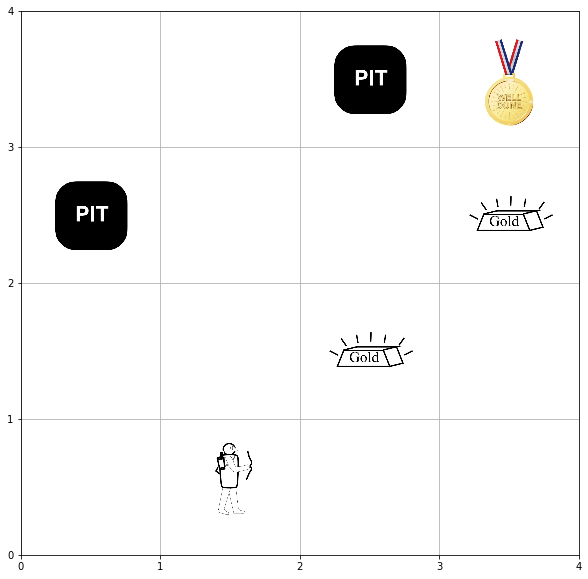


--------------- After Timestep 3 ---------------
current state: [0, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


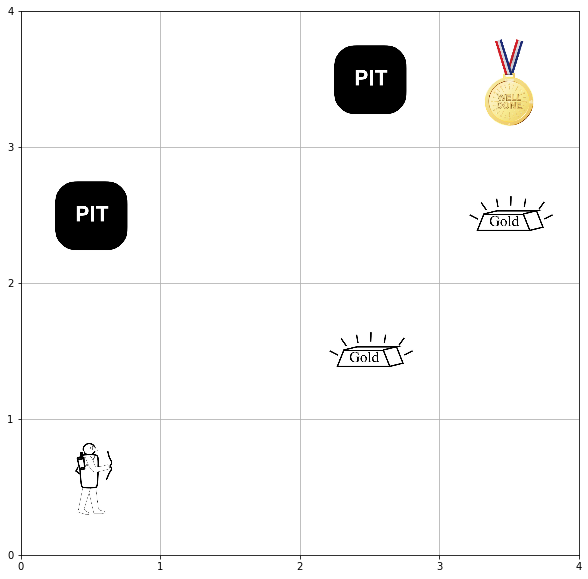


--------------- After Timestep 4 ---------------
current state: [0, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


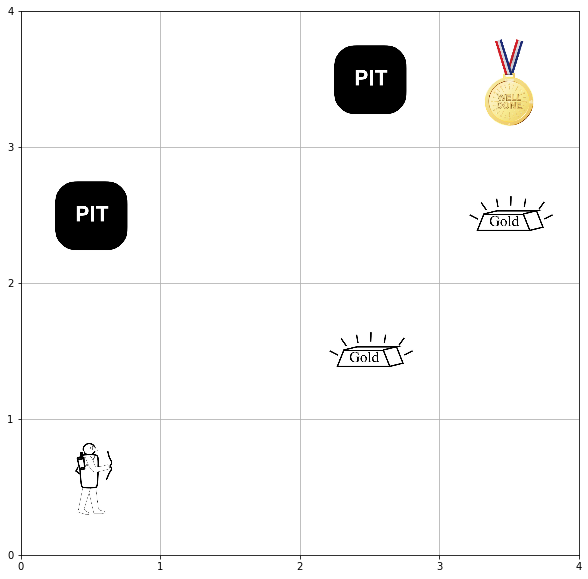


--------------- After Timestep 5 ---------------
current state: [0, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


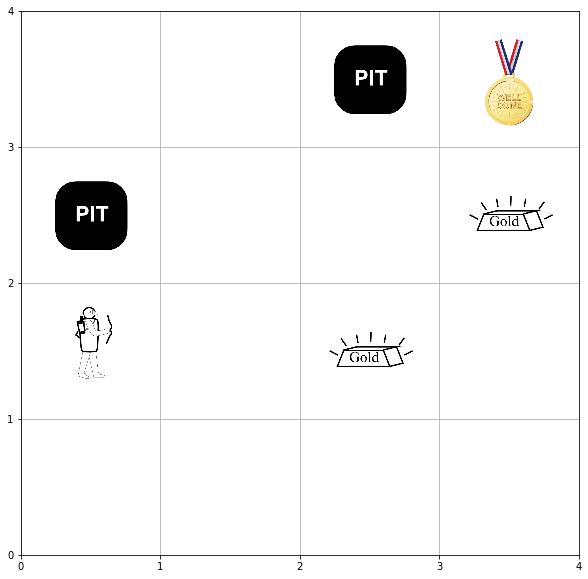


--------------- After Timestep 6 ---------------
current state: [0, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


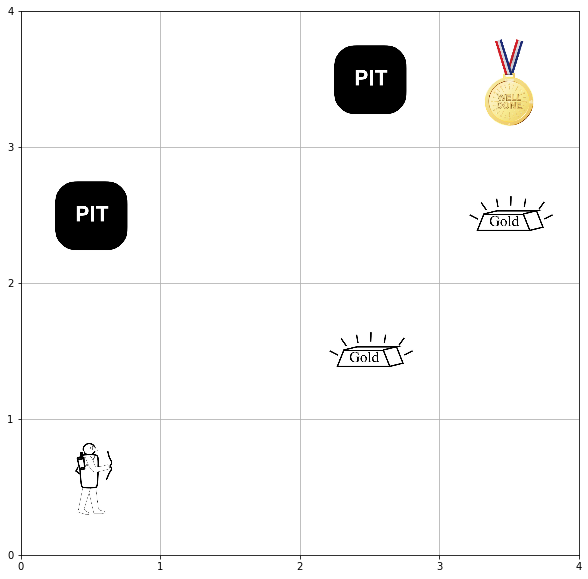


--------------- After Timestep 7 ---------------
current state: [0, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


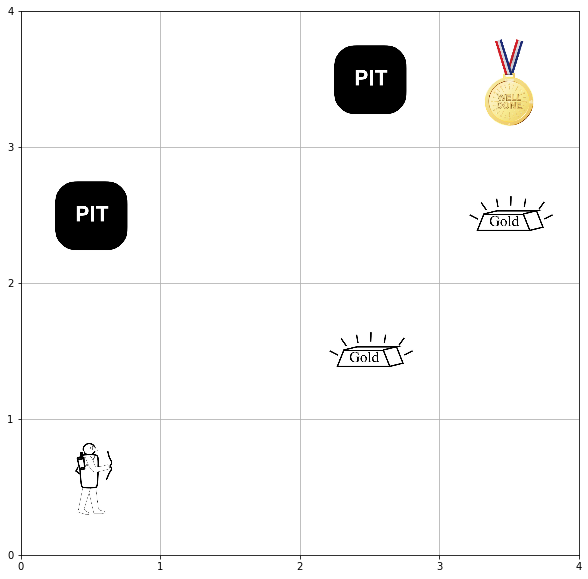


--------------- After Timestep 8 ---------------
current state: [1, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


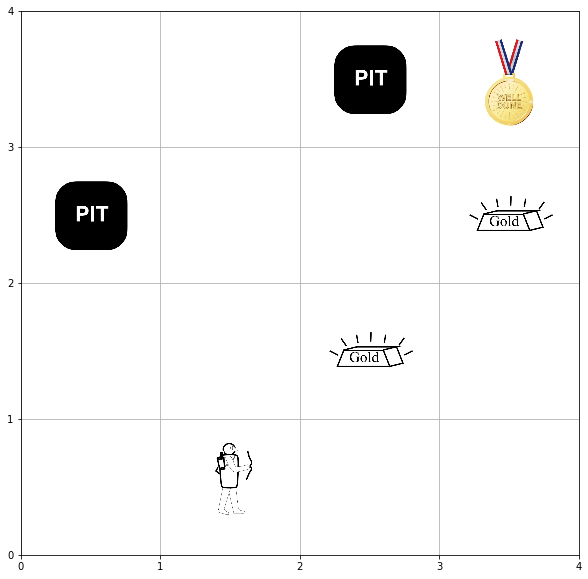


--------------- After Timestep 9 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


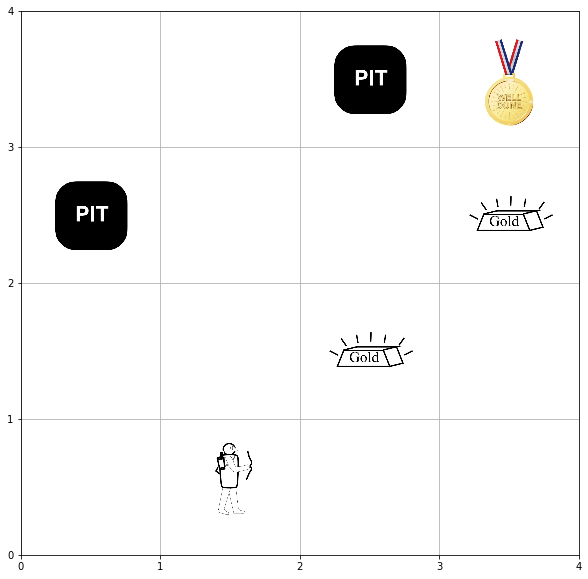


--------------- After Timestep 10 ---------------
current state: [2, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


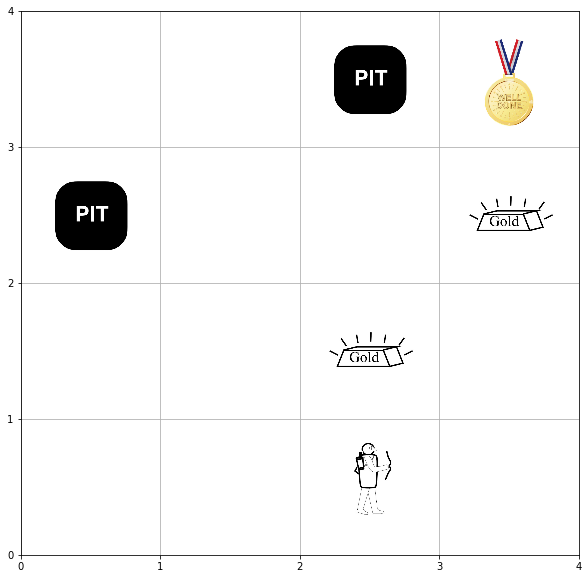


--------------- After Timestep 11 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


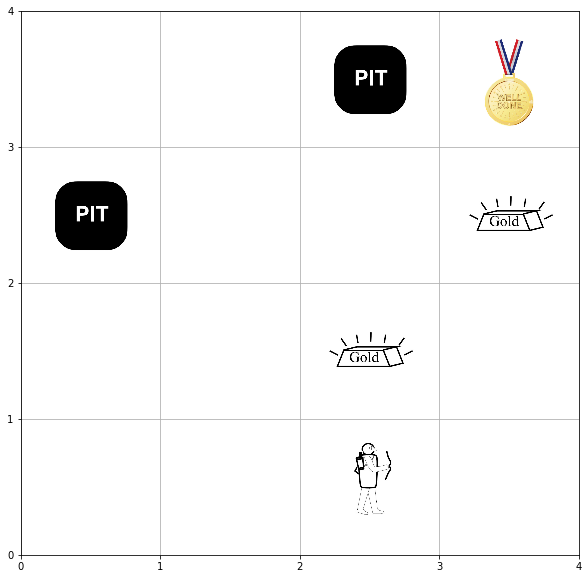


--------------- After Timestep 12 ---------------
current state: [2, 1]
chosen action: Right
reward after current step: 6.0
Total reward: 6.0


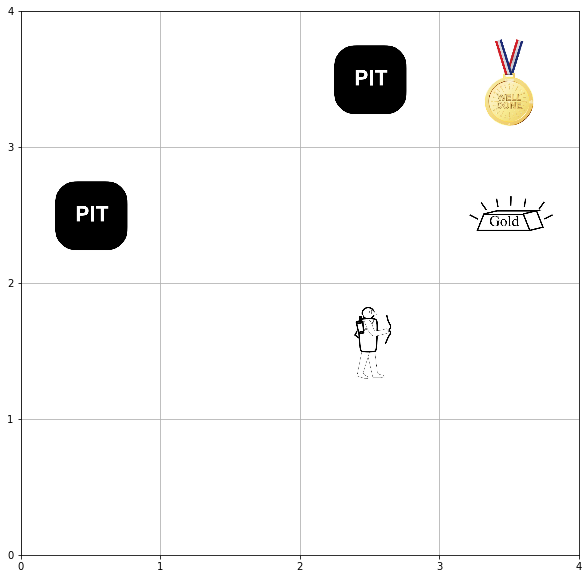


 ************* Episode 1 ends, Cumulative Rewards = 6.0 ************* 


 ************* Resetting the environment ************* 

************* Episode 2 *************
--------------- initial state ---------------
current state: [0, 0]


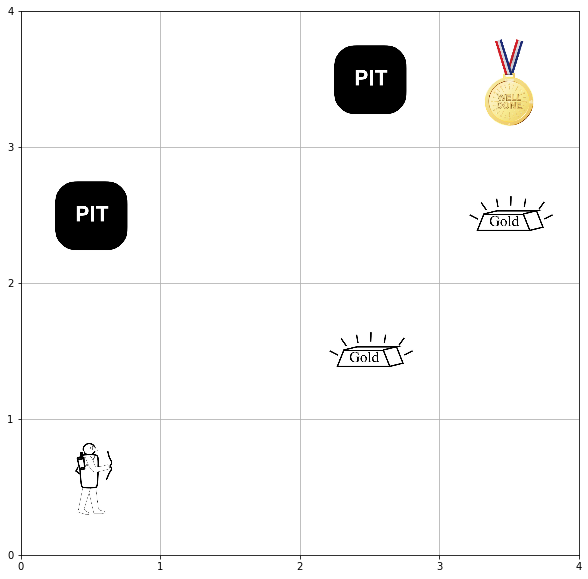


--------------- After Timestep 1 ---------------
current state: [0, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


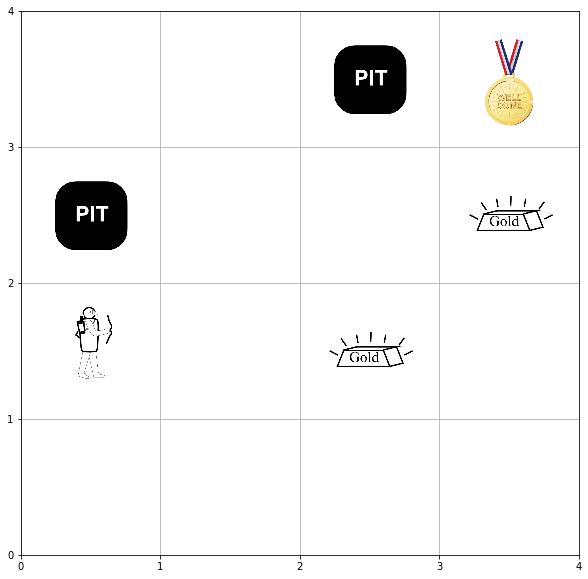


--------------- After Timestep 2 ---------------
current state: [1, 1]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


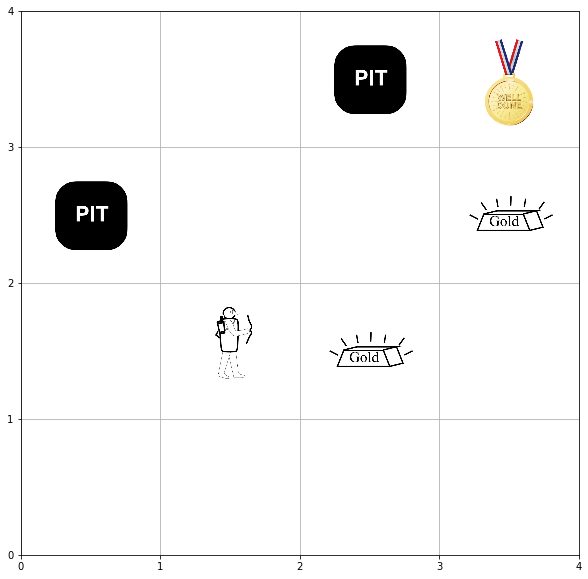


--------------- After Timestep 3 ---------------
current state: [2, 1]
chosen action: Down
reward after current step: 6.0
Total reward: 6.0


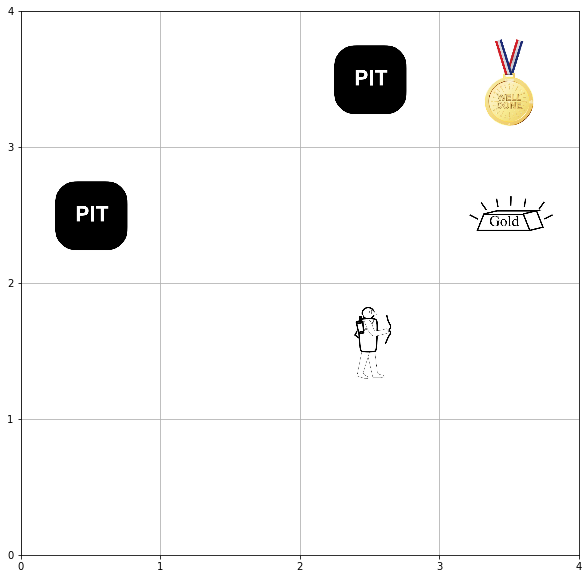


--------------- After Timestep 4 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 6.0


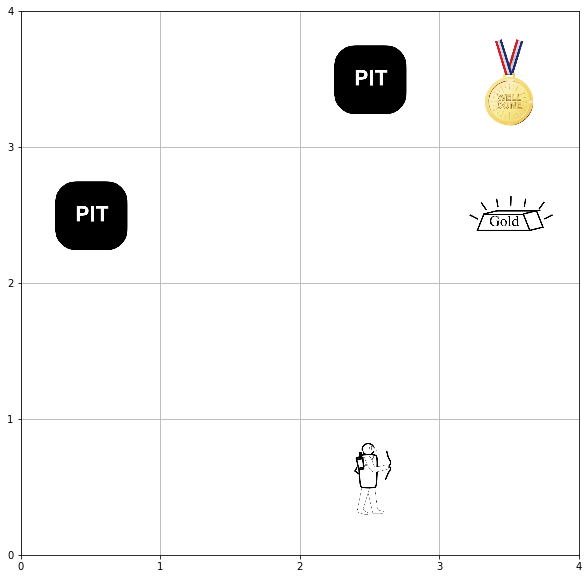


--------------- After Timestep 5 ---------------
current state: [1, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 6.0


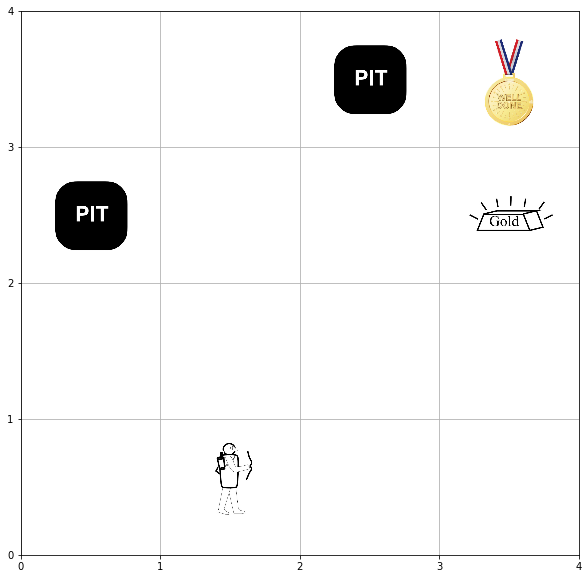


--------------- After Timestep 6 ---------------
current state: [2, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 6.0


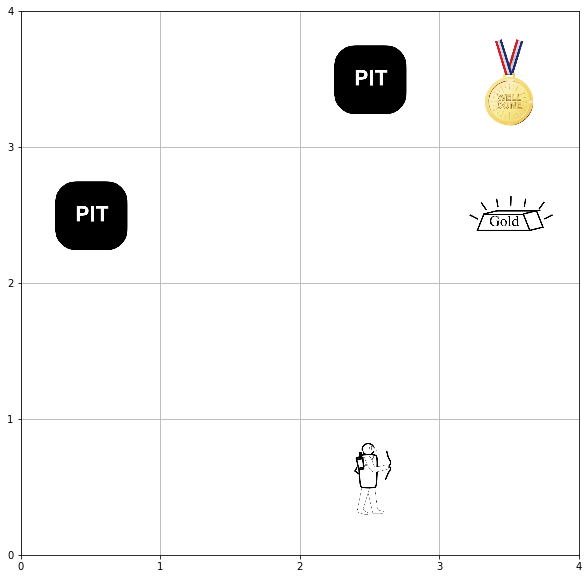


--------------- After Timestep 7 ---------------
current state: [2, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 6.0


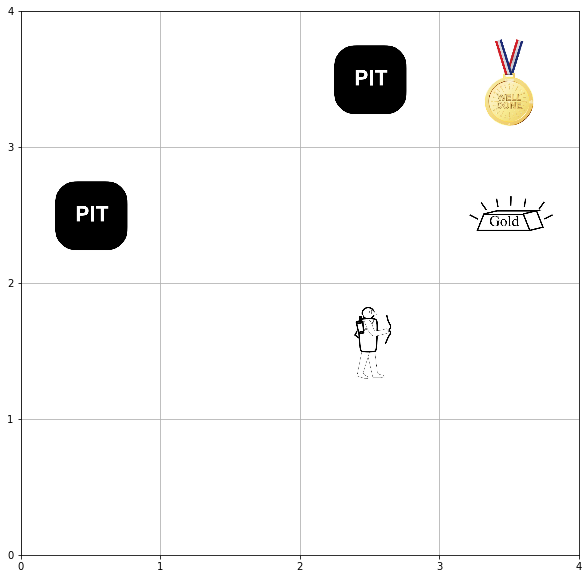


--------------- After Timestep 8 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 6.0


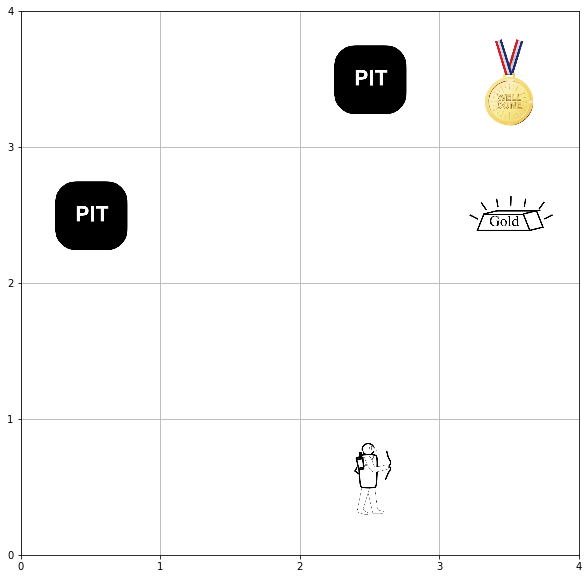


--------------- After Timestep 9 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 6.0


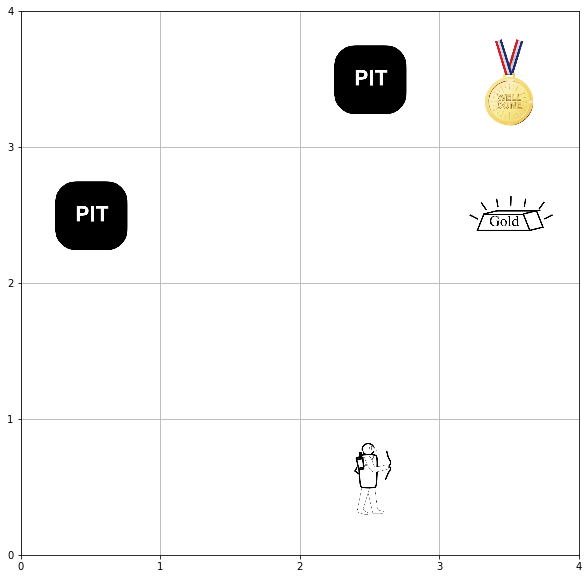


--------------- After Timestep 10 ---------------
current state: [2, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 6.0


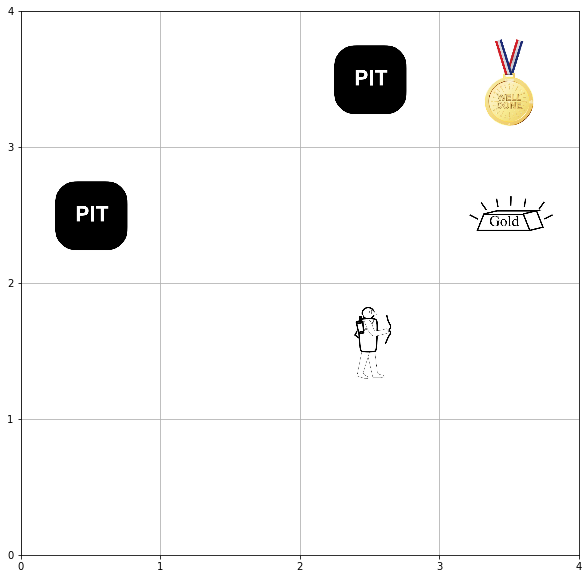


--------------- After Timestep 11 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 6.0


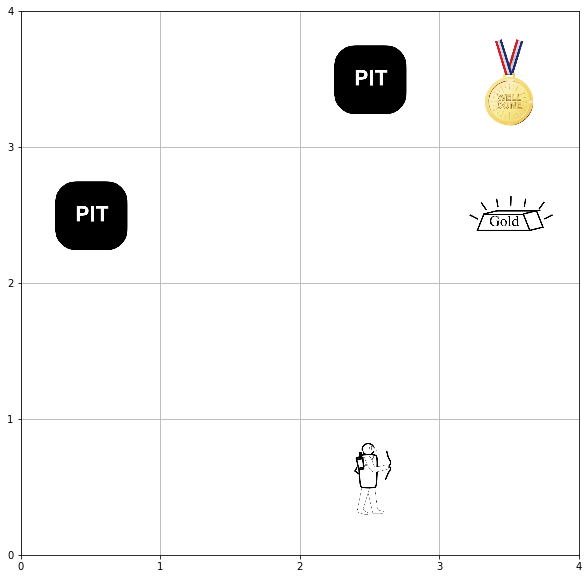


--------------- After Timestep 12 ---------------
current state: [2, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 6.0


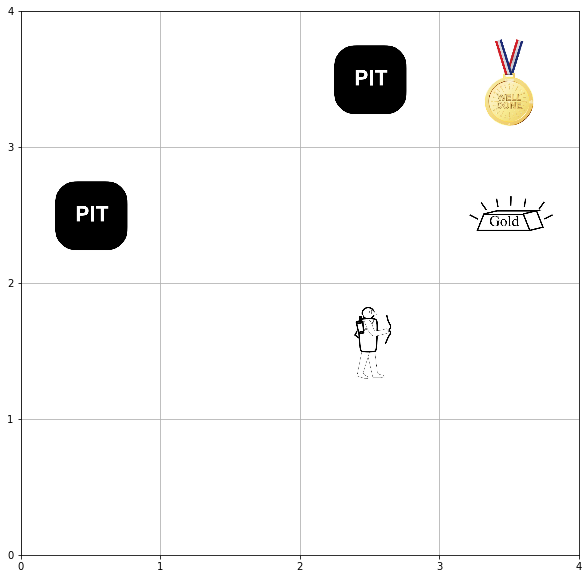


 ************* Episode 2 ends, Cumulative Rewards = 6.0 ************* 


 ************* Resetting the environment ************* 



In [25]:
env = LawnMowerDeterministicEnvironment(max_steps=12)
RandomAgent(env)

#Stochastic Environment

In [26]:
class LawnmoverStochasticEnvironment(gym.Env):
  metadata = {'render.modes' : []} 
  def __init__(self, n_rows = 4, n_columns = 4, A_pos = [0, 0], G_pos = [3, 3], max_steps = 15):
    # n_rows * n_columns states
    self.observation_space = spaces.Discrete(n_rows * n_columns)
    self.n_states = n_rows * n_columns
    self.n_rows = n_rows
    self.n_columns = n_columns
    
    # Possible actions [Up, Right, Down, Left]
    self.action_space = spaces.Discrete(4)
    self.n_actions = 4

    # Initialization of the State
    self.state = np.zeros((n_rows, n_columns))

    # Initial position of the agent
    self.agent_pos = [element for element in A_pos]
    self.start_pos = [element for element in A_pos]

    # Goal position
    self.goal_pos = [element for element in G_pos]

    # Positive Rewards Placement
    self.positive_Reward_Pos = [[3, 2], [2, 1], [3, 3]]
    self.state[tuple(self.positive_Reward_Pos[0])] = 10
    self.state[tuple(self.positive_Reward_Pos[1])] = 14
    self.state[tuple(self.goal_pos)] = 20

    # Negative Rewards Placement
    self.negative_Reward_Pos = [[0, 2], [2, 3]]
    self.state[tuple(self.negative_Reward_Pos[0])] = -15
    self.state[tuple(self.negative_Reward_Pos[1])] = -13
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    self.max_Timestep = max_steps
    
    
    
  def reset(self):
    # Initialization of the state
    self.state = np.zeros((self.n_rows, self.n_columns))

    # Initial position of the agent
    self.agent_pos = [element for element in self.start_pos]

    # Positive Rewards Placement
    self.state[tuple(self.positive_Reward_Pos[0])] = 5
    self.state[tuple(self.positive_Reward_Pos[1])] = 6
    self.state[tuple(self.goal_pos)] = 10

    # Negative Rewards Placement
    self.state[tuple(self.negative_Reward_Pos[0])] = -5
    self.state[tuple(self.negative_Reward_Pos[1])] = -6
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    
  def clip(self):
    '''clips the position if it goes out of bounds'''
    if self.agent_pos[0] < 0:
      self.agent_pos[0] = 0
    elif self.agent_pos[0] >= self.n_rows:
      self.agent_pos[0] = self.n_rows - 1
    if self.agent_pos[1] < 0:
      self.agent_pos[1] = 0
    elif self.agent_pos[1] >= self.n_columns:
      self.agent_pos[1] = self.n_columns - 1
    pass

  def step(self, action):
    '''
      Input - Action: 0[Up], 1[Right], 2[Down], 3[Left]
      Returns -
        agent_pos - Agent current position after applying the move
        reward - Reward gained by current action
        done - Goal reached status (True/False)
        info - Additional info if any
    '''
    self.state[tuple(self.agent_pos)] = 0
    probability = random.random()
    #The probability of occuring a random action instead of the specified one by the agent is 0.2
    if probability < 0.2:
      prev_action = action
      action = self.action_space.sample()
      while prev_action == action:
        action = self.action_space.sample()
      map_action = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}
      print("updated action in stochastic environment:",  map_action[action])
      
    if action == 0: #Up
      self.agent_pos[0] -= 1
    elif action == 1: #Right
      self.agent_pos[1] += 1
    elif action == 2: #Down
      self.agent_pos[0] += 1
    elif action == 3: #Left
      self.agent_pos[1] -= 1
    
    self.clip()

    cur_reward = self.state[tuple(self.agent_pos)]
    
    self.total_reward += cur_reward
    self.state[tuple(self.agent_pos)] = 1
    self.timestep += 1

    self.done = True if (self.agent_pos == self.goal_pos or self.timestep >= self.max_Timestep) else False
    info = {}
    observation = self.state.flatten()
    return observation, cur_reward, self.done, info
    

  def render(self):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    def plot_image(plot_pos):
      #print(plot_pos)
      plot_agent, plot_gold, plot_pit, plot_dest = False, False, False, False
      if np.array_equal(self.agent_pos, plot_pos):
        plot_agent = True
      elif np.array_equal(plot_pos, self.goal_pos):
        plot_dest = True
      elif self.state[tuple(plot_pos)] > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
        plot_gold = True
      elif self.state[tuple(plot_pos)] < 0:
        plot_pit = True
      #if any(np.array_equal(self.negative_Reward_Pos[i], plot_pos) for i in range(len(self.negative_Reward_Pos))):
       # plot_pit = True
      #if any(np.array_equal(self.postive_Reward_Pos[i], plot_pos) for i in range(len(self.postive_Reward_Pos))):
       # plot_gold = True
      if plot_agent and all(not item for item in
                        [plot_gold, plot_pit, plot_dest]):
        agent = AnnotationBbox(OffsetImage(plt.imread('wumpus.png'), zoom=0.15),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(agent)
      elif plot_gold and \
                    all(not item for item in
                        [plot_agent, plot_pit, plot_dest]):
                gold = AnnotationBbox(OffsetImage(plt.imread('gold.png'), zoom=0.15),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(gold)
      elif plot_pit and \
                    all(not item for item in
                        [plot_gold, plot_agent, plot_dest]):
                pit = AnnotationBbox(OffsetImage(plt.imread('pit.png'), zoom=0.15),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      elif plot_dest and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_agent]):
                pit = AnnotationBbox(OffsetImage(plt.imread('destination.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      else:
        pit = AnnotationBbox(OffsetImage(plt.imread('empty.png'), zoom=0.25),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(pit)
    coordinates_state_mapping_2 = {}
    for j in range(4 * 4):
        coordinates_state_mapping_2[j] = np.asarray(
            [j % 4, int(np.floor(j / 4))])

    # Images Rendering for all the states.
    for position in coordinates_state_mapping_2:
      plot_image(coordinates_state_mapping_2[position])

    plt.xticks([0, 1, 2, 3, 4])
    plt.yticks([0, 1, 2, 3, 4])
    plt.grid()
    plt.show()


In [27]:
def Stochastic_RandomAgent(env):
  map_action = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}
  for i in range(2):
    print(f"************* Episode {i+1} *************")
    env.reset()
    print("--------------- initial state ---------------")
    print("current state:", env.agent_pos)
    env.render()

    for step in range(0,env.max_Timestep):
      action = env.action_space.sample()
      observation, reward, done, _ = env.step(action)
      print(f"\n--------------- After Timestep {step+1} ---------------")
      print("current state:", env.agent_pos)
      print("chosen action:",  map_action[action])
      print("reward after current step:",  reward)
      print("Total reward:", env.total_reward)
      env.render()
      if done:
        #env.render()
        print(f"\n ************* Episode {i+1} ends, Cumulative Rewards = {env.total_reward} ************* \n")
        print("\n ************* Resetting the environment ************* \n")
        break



************* Episode 1 *************
--------------- initial state ---------------
current state: [0, 0]


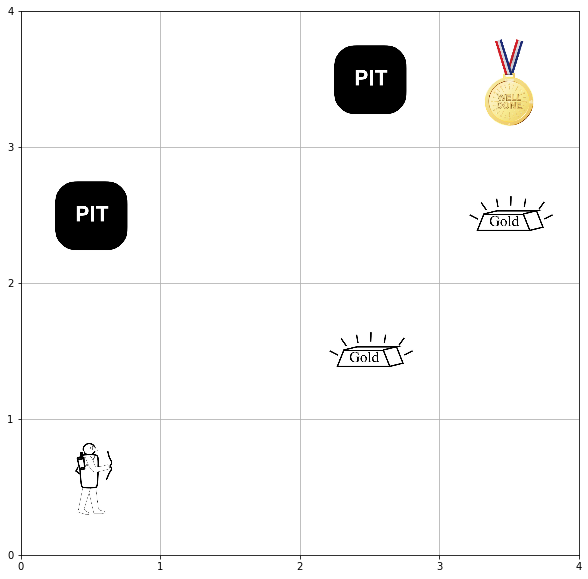


--------------- After Timestep 1 ---------------
current state: [1, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


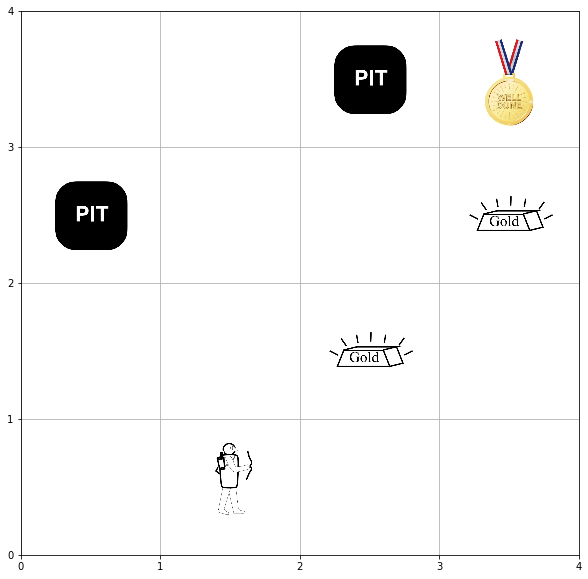


--------------- After Timestep 2 ---------------
current state: [2, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


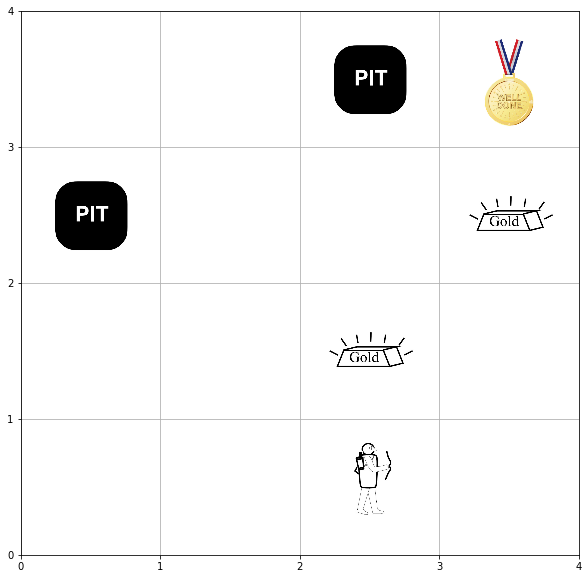


--------------- After Timestep 3 ---------------
current state: [3, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


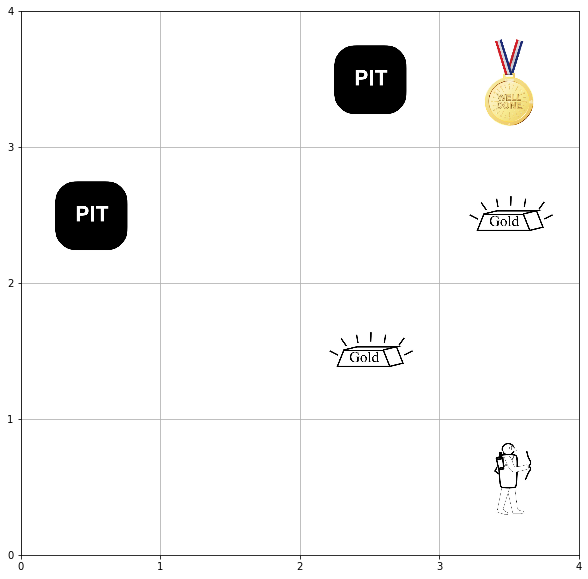


--------------- After Timestep 4 ---------------
current state: [3, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


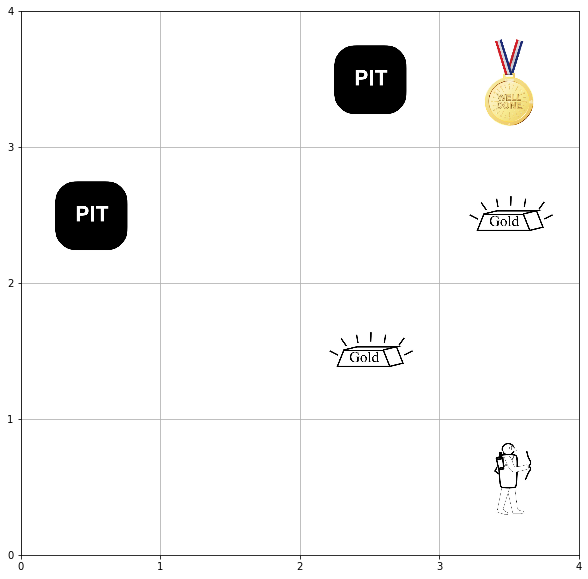

updated action in stochastic environment: Left

--------------- After Timestep 5 ---------------
current state: [3, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


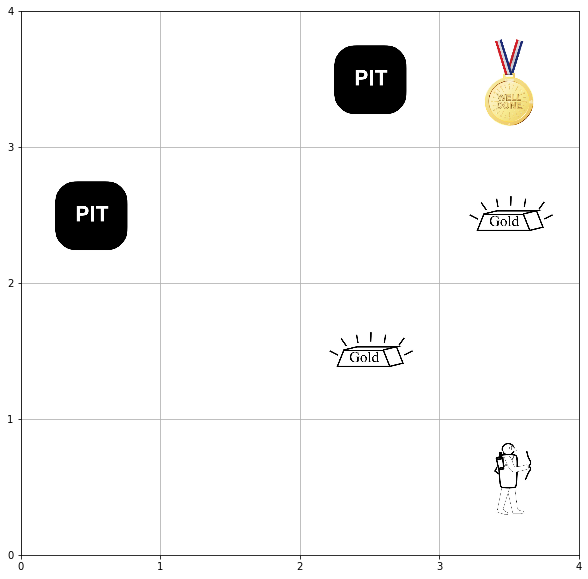


--------------- After Timestep 6 ---------------
current state: [3, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


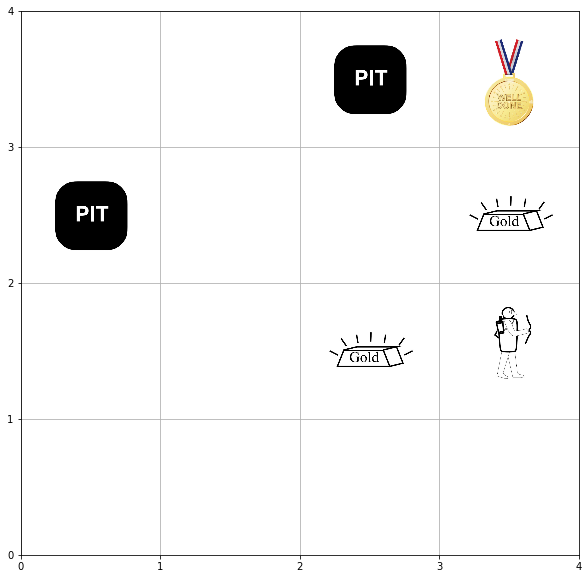


--------------- After Timestep 7 ---------------
current state: [2, 1]
chosen action: Up
reward after current step: 6.0
Total reward: 6.0


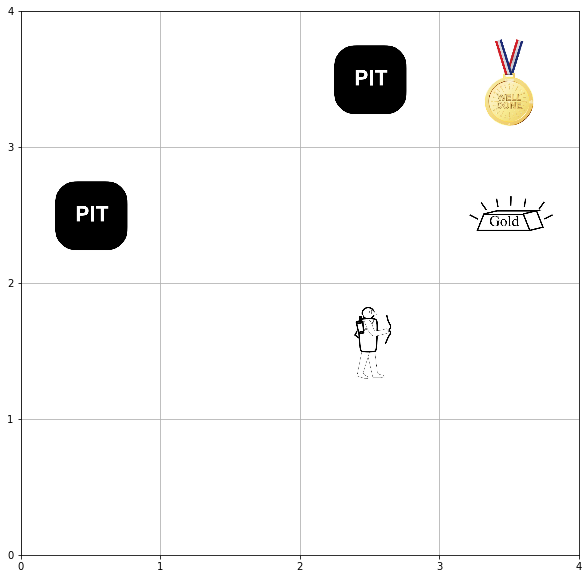


--------------- After Timestep 8 ---------------
current state: [1, 1]
chosen action: Up
reward after current step: 0.0
Total reward: 6.0


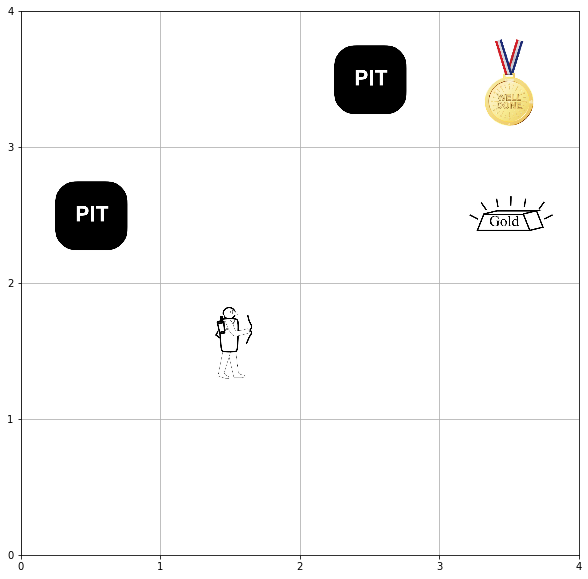


--------------- After Timestep 9 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 6.0


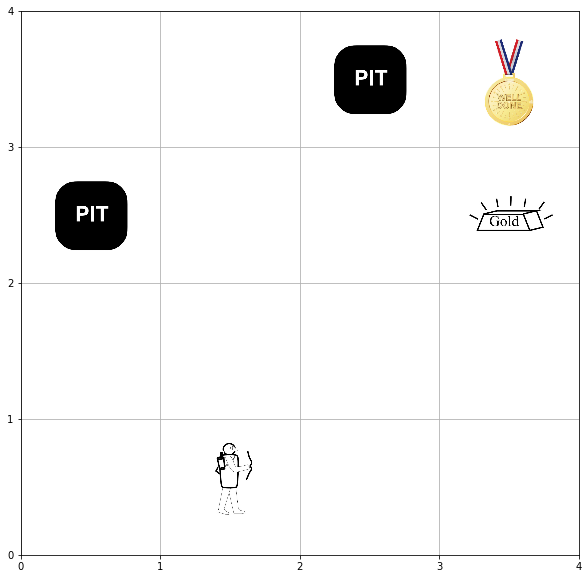

updated action in stochastic environment: Left

--------------- After Timestep 10 ---------------
current state: [1, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 6.0


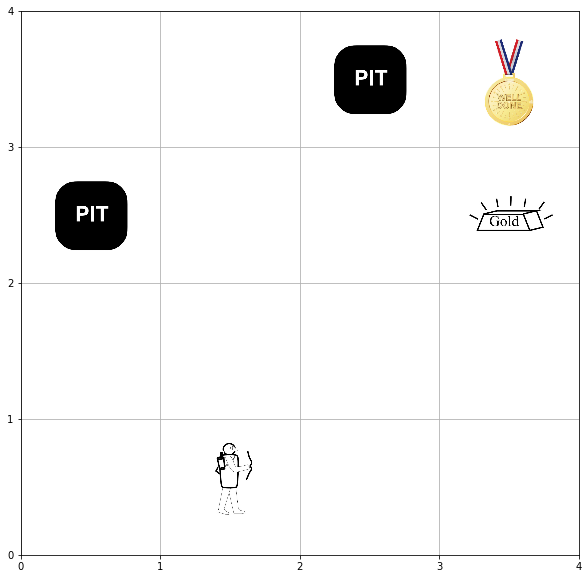

updated action in stochastic environment: Down

--------------- After Timestep 11 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 6.0


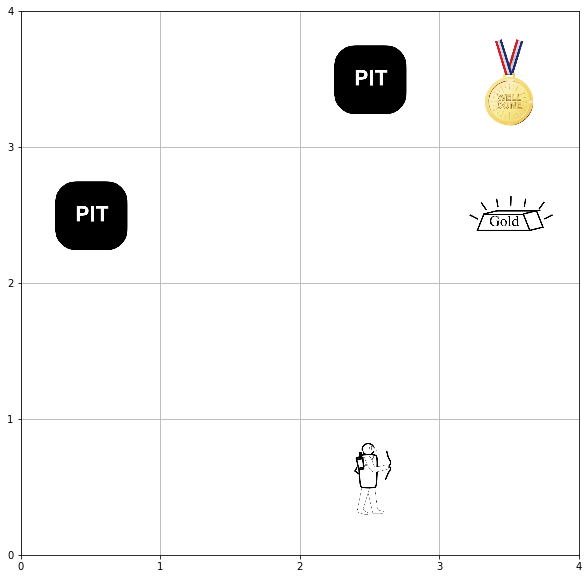

updated action in stochastic environment: Up

--------------- After Timestep 12 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 6.0


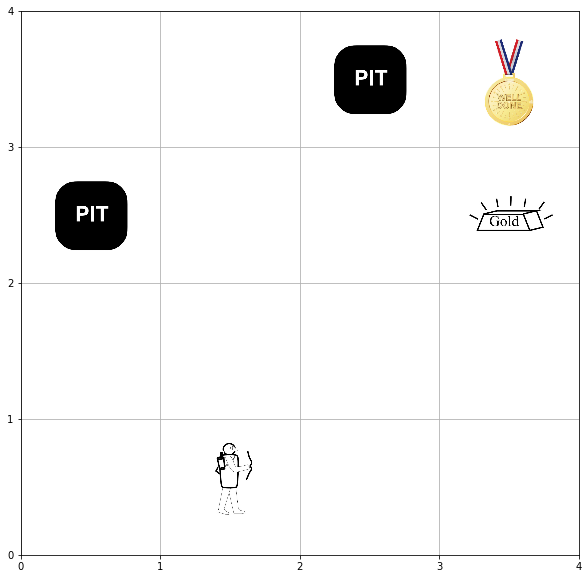


 ************* Episode 1 ends, Cumulative Rewards = 6.0 ************* 


 ************* Resetting the environment ************* 

************* Episode 2 *************
--------------- initial state ---------------
current state: [0, 0]


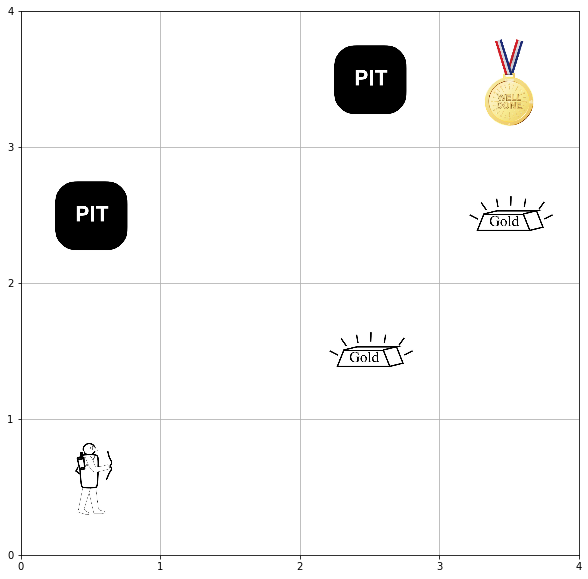


--------------- After Timestep 1 ---------------
current state: [0, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


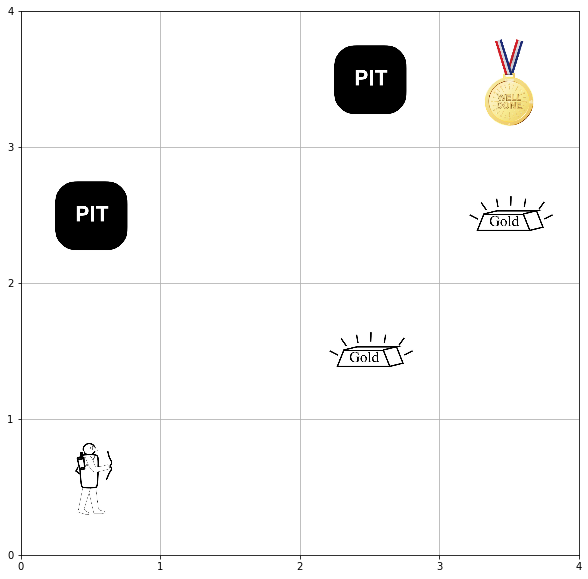

updated action in stochastic environment: Right

--------------- After Timestep 2 ---------------
current state: [0, 1]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


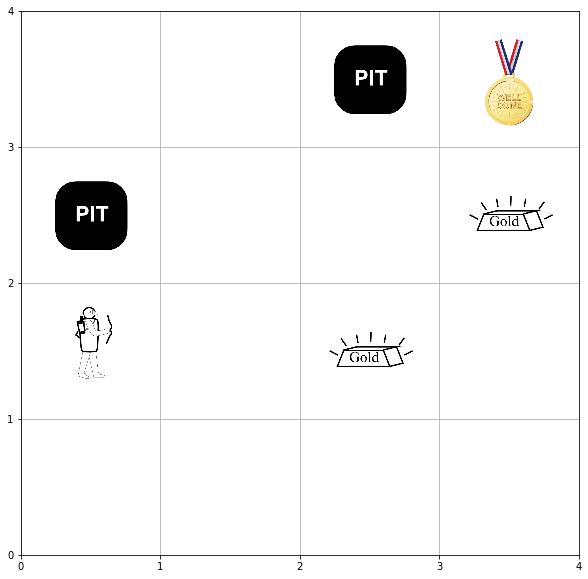


--------------- After Timestep 3 ---------------
current state: [1, 1]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


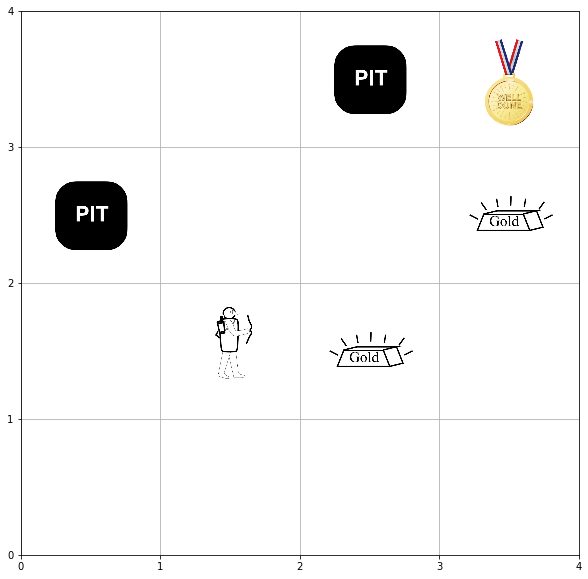

updated action in stochastic environment: Up

--------------- After Timestep 4 ---------------
current state: [0, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


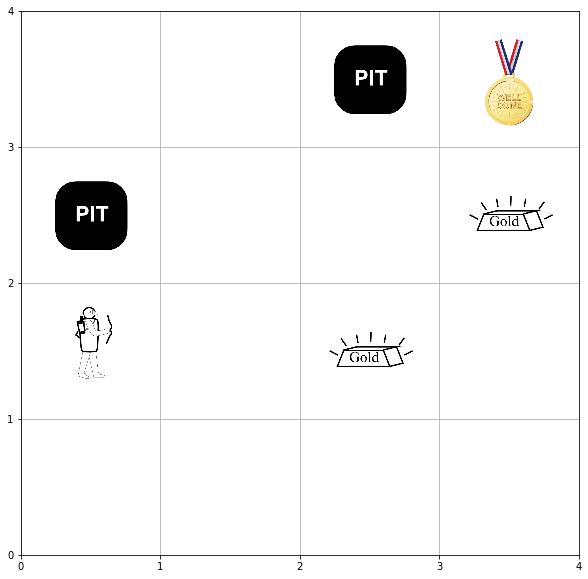


--------------- After Timestep 5 ---------------
current state: [1, 1]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


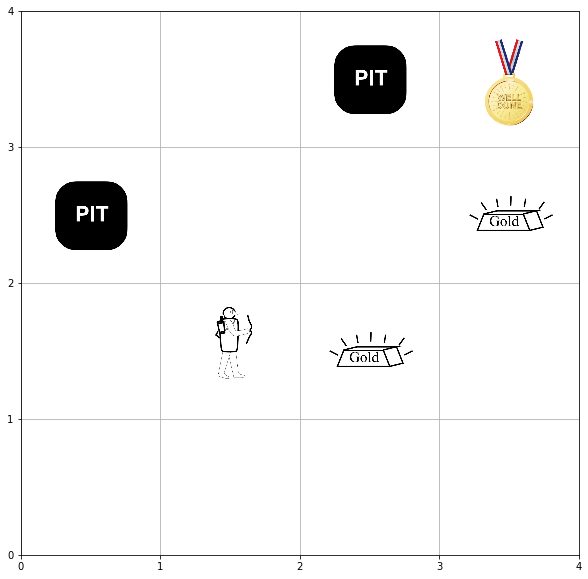


--------------- After Timestep 6 ---------------
current state: [1, 2]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


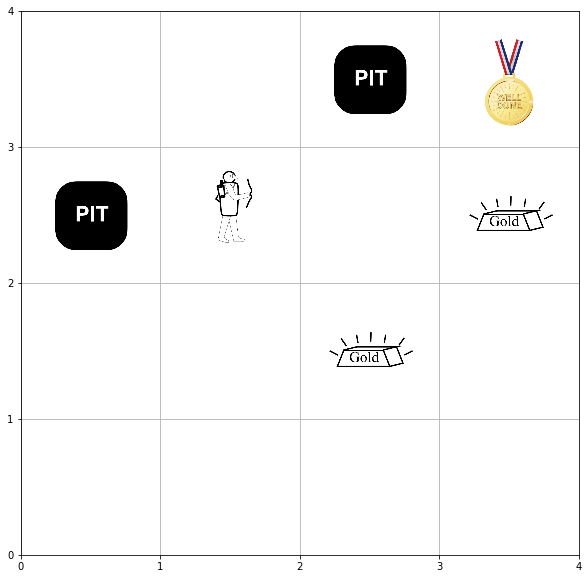


--------------- After Timestep 7 ---------------
current state: [1, 1]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


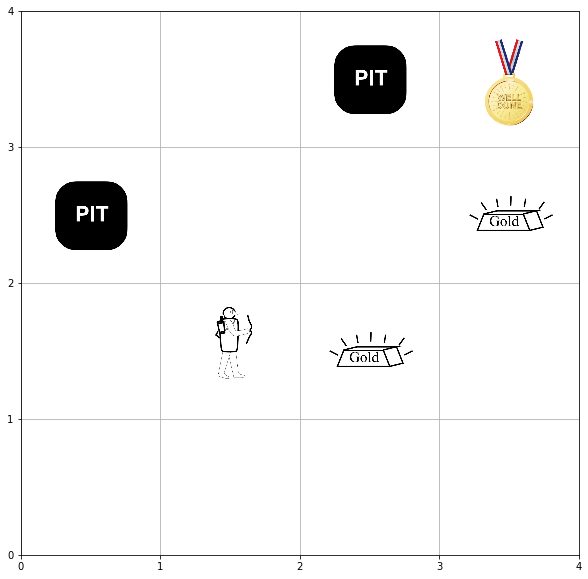


--------------- After Timestep 8 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


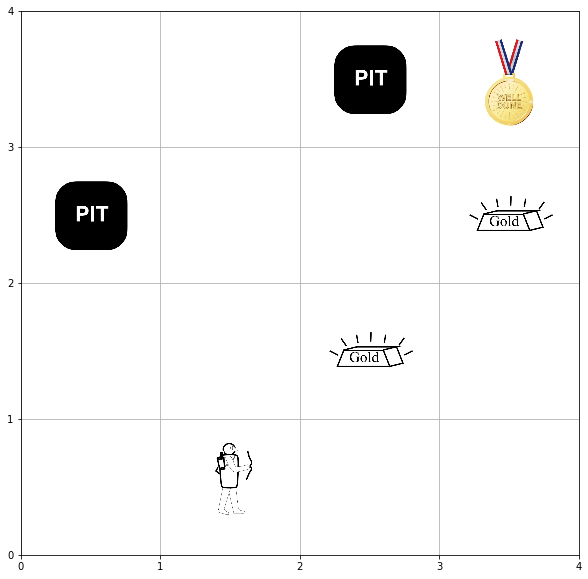


--------------- After Timestep 9 ---------------
current state: [0, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


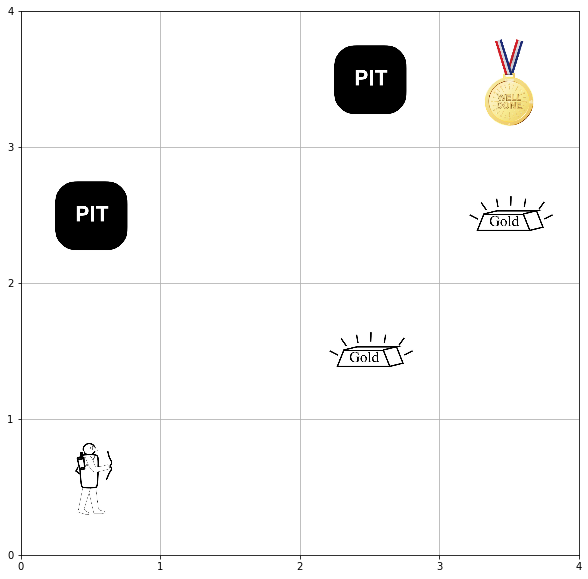


--------------- After Timestep 10 ---------------
current state: [1, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


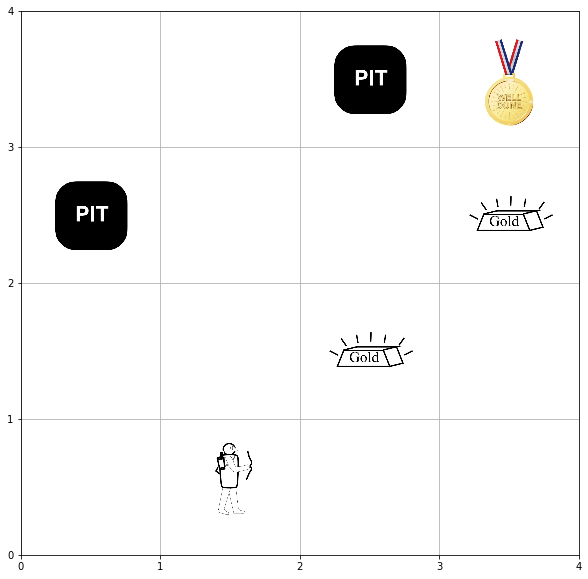


--------------- After Timestep 11 ---------------
current state: [0, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


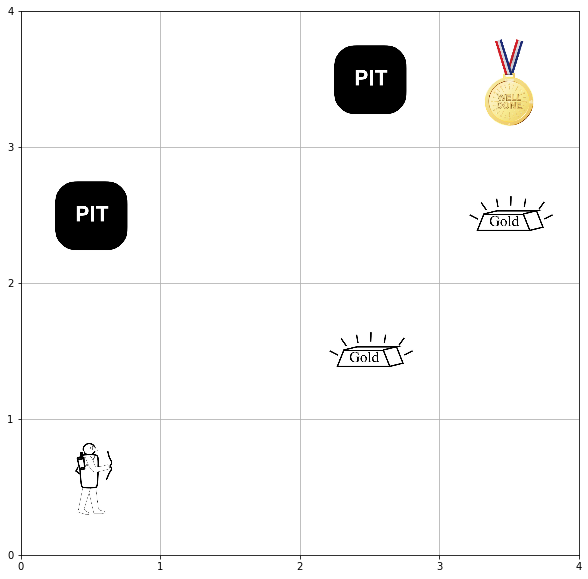


--------------- After Timestep 12 ---------------
current state: [0, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


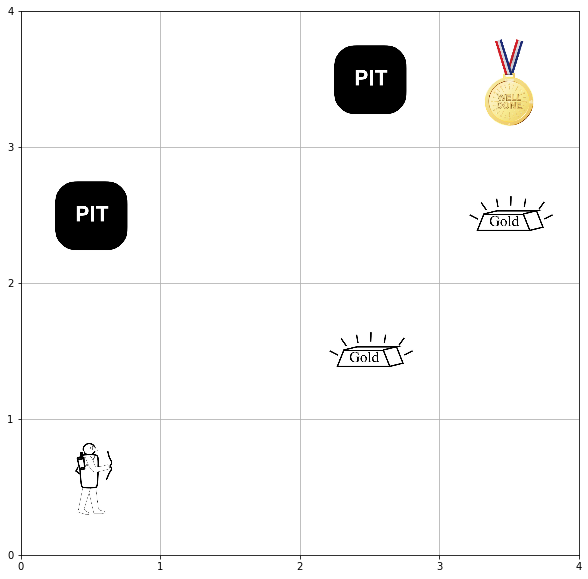


 ************* Episode 2 ends, Cumulative Rewards = 0.0 ************* 


 ************* Resetting the environment ************* 



In [28]:
s_env = LawnmoverStochasticEnvironment(max_steps=12)
Stochastic_RandomAgent(s_env)